# **Multilingual - mBERT CELF Classifier - Experiment 3**

### **Multiclass and Multilabel Text Classification in ALL-in-One BERT Model with Data Augmentation**



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pandas --quiet


!pip install -q transformers --quiet
!pip install transformers[torch] --quiet
!pip install transformers[sentencepiece] --quiet
!pip install datasets --quiet
!pip install --upgrade gensim --quiet
!pip install sacremoses --quiet
# Install the nlpaug module
!pip install nlpaug --quiet

# Install the tokenizer
import sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 9.1 MB/s eta 0:00:00


In [3]:
# Import the nlpaug module and its methods
import nlpaug.augmenter.word as naw
import nlpaug.flow as nafc
from nlpaug.util import Action

In [4]:
import os
import pandas as pd
import numpy as np
import transformers
import tensorflow as tf
import torch
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig, AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, Trainer, TrainerCallback, TrainingArguments

from datasets import Dataset, load_metric, DatasetDict

import matplotlib.pyplot as plt
import gc

In [5]:
# Use GPU (cuda) if available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Load and examine data**

before we start plotting, it's always good to display the first few lines to see what we're dealing with.

## **Modelling Approaches**


- Classification: We can look at the problem as a classification problem - A sentence/responce will belong to one of the five scores and to one of the 9 structures.

- Ordinal Regression: A sentence will set a score in the interval between 0 and 3.

### **Fine-tuning a text classification model from the transformers library.**

- We'll use the mBERT base wrapped in the AutoModelForSequenceClassification.

- multilingual AutoTokenizer.  

- A Data collector with Padding: to ensure that all the inputs have the same length.

- A Dataloader to avoid memory issues.



### **Farsi Labels**


In [6]:
# Set the model path
PATH = "/content/drive/MyDrive/data/mBERT"

# Define the tokenizer
tokenizer = AutoTokenizer.from_pretrained(PATH)

### **Define Special Validation Set**

In [7]:
import pandas as pd

# Load the dataset into a Pandas dataframe. This is where the data from the second/ Third language comes.
#df_test = pd.read_csv("/content/drive/MyDrive/data/farsi/farsiCELF.csv", on_bad_lines='skip', encoding='ISO-8859-1')
df_test = pd.read_csv("/content/drive/MyDrive/data/multilingual/allDataCELF.csv",  keep_default_na=False, sep = ";")
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

df_test.columns

Number of test sentences: 3,301



Index(['TARGET', 'RESPONSE', 'AUTO_SCORING', 'TOLD_SCORING', 'CELF_SCORING'], dtype='object')

In [9]:
All_text = df_test.rename(columns = {"CELF_SCORING": "label", "RESPONSE": "text"})

In [10]:
All_text = All_text.dropna()

## **Prepare the Data**

tokenise the dataset by calling tokenizer


1) **First:** Lets split the data into train, test. and val.

In [11]:
from sklearn.model_selection import train_test_split

#split bulk data into train and test set
train,test = train_test_split(All_text, test_size=0.30, random_state=23)

#split the training into validation and test set
test,val = train_test_split(test, test_size=0.50, random_state=23)

#save the data
train.to_csv('ASrtTrain.csv',index=False)
test.to_csv('ASrtTest.csv',index=False)
val.to_csv('ASrtVal.csv', index=False)

train.shape, val.shape, test.shape

((2310, 5), (496, 5), (495, 5))

2) **Second:** Lets save the respective datasFrame splits

In [12]:
train_ds = pd.read_csv("/content/ASrtTrain.csv").astype(str)
val_ds = pd.read_csv("/content/ASrtVal.csv").astype(str)
test_ds = pd.read_csv("/content/ASrtTest.csv").astype(str)

3) **Third:** Lets convert the DataFrames into DataSets that we can work with.

In [13]:
from datasets import Dataset

ds_train = Dataset.from_pandas(train)
ds_val = Dataset.from_pandas(val)
ds_test = Dataset.from_pandas(test)

4) **Fourth** Lets gather train, val, and test DataSets into a single DatasetDict that we can easily manipulatable.

In [14]:
# Gather train, val, and test Datasets to have a single DatasetDict, and make it manipulatable
sentences = DatasetDict({
    'train': ds_train,
    'val': ds_val,
    'test': ds_test})

# Dataset.from_pandas will add an index column, which can be removed
sentences = sentences.remove_columns(["__index_level_0__"])

In [15]:
# Specify the model checkpoint
# Note: Find pre-trained models that support AutoModelForSequenceClassification:
# https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification
model = PATH

# Load the tokenizer from the pretrained model
tokenizer = AutoTokenizer.from_pretrained(model)

In [16]:
def tokenize(batch):
  return tokenizer(
    batch["text"],
    # Pad the examples with zeros to the size of the longest one in a batch
    padding = True,
    # Truncate the examples to the model’s maximum context size (which is 512 for this model)
    truncation = True)

In [17]:
# Once we’ve defined a processing function, we can apply it across all the splits in the DataDict.
text_encoded = sentences.map(
  tokenize,
  # Encode the sentences in batches
  batched = True,
  # Apply the tokenize function on the full dataset as a single batch
  # Note: This ensures that the input tensors and attention masks have the same shape globally
  # Alternatively, we can specify max_length in the tokenize() function to ensure the same
  batch_size = None)

Map:   0%|          | 0/2310 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/496 [00:00<?, ? examples/s]

Map:   0%|          | 0/495 [00:00<?, ? examples/s]

In [18]:
# Remove the text column from the encoded DatasetDict because the model does not use# it.
text_encoded = text_encoded.remove_columns(['token_type_ids', 'text'])

# Since the model expects tensors as inputs,
# we will convert the input_ids and attention_mask columns to the "torch" format.
text_encoded.set_format("torch", columns = ["input_ids", "attention_mask", "label"])

In [21]:
# Define two dictionaries that convert between ids (0, 1, 2, 3) and labels (strings)
# Note: By adding label2id and id2label to our model's config,
# we will get friendlier labels in the inference API.
label2id = {}
id2label = {}
labels = ['incorrect', 'pass', 'acceptable ', 'correct']
for i, label_name in enumerate(labels):
  label2id[label_name] = str(i)
  id2label[str(i)] = label_name

# Take a look the two dictionaries
#label2id, id2label, len(label2id)


# **Training Parameters** (*change*)


To define the training parameters, we use the TrainingArguments class. This class stores a lot of information and gives you fine-grained control over the training and evaluation. The most important argument to specify is output_dir, which is where all the artifacts from training are stored.

In [22]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top

#model_ckpt = PATH
# Load the tokenizer from the pretrained model
#tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model = AutoModelForSequenceClassification.from_pretrained(
    PATH,                           # Use the 12-layer BERT model, with an uncased vocab.
    # Number of classes/labels
    num_labels = len(label2id),
    # A dictionary linking label to id
    label2id = label2id,
    # A dictionary linking id to label
    id2label = id2label)

#########################UNCOMMENT FOR FROZEN PARAMETERS##########################
"""
for name, param in model.named_parameters():
	if 'classifier' not in name: # classifier layer
		param.requires_grad = False

## FullFreeze
#list(model.parameters())[5].requires_grad = True
#list(model.parameters())[-4].requires_grad = True

## DeepFreeze+pooler
#list(model.parameters())[53].requires_grad = True
#list(model.parameters())[-4].requires_grad = True
"""
#########################UNCOMMENT FOR FROZEN PARAMETERS##########################

model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/data/mBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

## **Prepare the Metrics**
During the training phase logits are built, from which the HugginFace transformer will deduce relations and predicted vectors. They will be compared with the labels and returned as framed metrics including *accuracy, precision, recall and f1-scores*

in **multiclass classification** the predicted vector is reached by assigning a 1 tot he highest logit and 0 to all others, using the softMax the class witht he highest probability will have the highest score.

in **multilabel classification** deduces the predicted vector by assigning 1 to all non-negative logits and 0 to all negative logits. >=0.5 probability belongs to the coressponding class.


### **Alternative Compute Metrics**


Define the performance metrics

    To monitor metrics during training, we need to define a compute_metrics() function for the Trainer.

    For our application, we’ll compute the F1-score and the accuracy of the model.



In [23]:
# Define a function to compute two metrics--accuracy and f1 score
def compute_metrics(pred):
  # True labels
  labels = pred.label_ids
  # Predicted labels
  # Note: argmax(-1) will get the index/label_id correponding to the largest value in `predictions`
  preds = pred.predictions.argmax(-1)
  # Note: average = "weighted" will weigh the f1_score by class sample size
  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)
  # Note: Need to return a dictionary
  return {"accuracy": acc, "f1": f1}

## Batchsize, Epochs and Trainer (*change*)


To define the training parameters, we use the TrainingArguments class. This class stores a lot of information and gives you fine-grained control over the training and evaluation. The most important argument to specify is output_dir, which is where all the artifacts from training are stored.


In [24]:
## Define the training arguments

# Batch size
batch_size = 32

# Number of epochs
num_epochs = 4

output_dir = input("Please enter the output directory: ")


# Training argument
training_args = TrainingArguments(
  # Output directory
  # Note: All model checkpoints will be saved to the folder named `model_name`
  output_dir = output_dir,
  # Number of epochs
  num_train_epochs = num_epochs,
  # Learning rate
  learning_rate = 2e-5,
  # Batch size for training and validation
  per_device_train_batch_size = batch_size,
  per_device_eval_batch_size = batch_size,
  # Weight decay for regularization
  weight_decay = 0.01,
  logging_steps = 73,
  # Validate the model using the val set after each epoch
  evaluation_strategy = "epoch",
  # Load the best model at the end of training
  load_best_model_at_end = True,
  # Push to Huggingface Hub
  # It could be helpful to push the model to the Hub for sharing and using pipeline(), but
  # it takes a very long time to push the model, so we choose not do it here.
  push_to_hub = False,
  # Save model checkpoint after each epoch
  save_strategy = "epoch")


Please enter the output directory: augmented_multiclass


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:

# Define the trainer
trainer = Trainer(
  # Model
  model = model,
  # Training argument
  args = training_args,
  # Metrics (f1 score and accuracy)
  compute_metrics = compute_metrics,
  # Train and val Datasets
  train_dataset = text_encoded["train"],
  eval_dataset = text_encoded["val"],
  # Tokenizer
  tokenizer = tokenizer)

In [26]:
# Clean up the memory using the garbage cleaner
gc.collect()
torch.cuda.empty_cache()

In [27]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.204000,1.063582,0.558468,0.422011
2,1.014900,0.927789,0.625000,0.538465
3,0.869300,0.855473,0.653226,0.585033
4,0.757800,0.833617,0.677419,0.627010


TrainOutput(global_step=292, training_loss=0.9614778675445138, metrics={'train_runtime': 42.8883, 'train_samples_per_second': 215.443, 'train_steps_per_second': 6.808, 'total_flos': 180439868568960.0, 'train_loss': 0.9614778675445138, 'epoch': 4.0})

In [ ]:
#trainer.state.log_history

[{'loss': 1.1263,
  'learning_rate': 1.5000000000000002e-05,
  'epoch': 1.0,
  'step': 73},
 {'eval_loss': 0.9554794430732727,
  'eval_accuracy': 0.6229838709677419,
  'eval_f1': 0.5252654722318003,
  'eval_runtime': 0.3044,
  'eval_samples_per_second': 1629.54,
  'eval_steps_per_second': 52.566,
  'epoch': 1.0,
  'step': 73},
 {'loss': 0.9117, 'learning_rate': 1e-05, 'epoch': 2.0, 'step': 146},
 {'eval_loss': 0.8467928171157837,
  'eval_accuracy': 0.6713709677419355,
  'eval_f1': 0.6134047637731479,
  'eval_runtime': 0.2903,
  'eval_samples_per_second': 1708.422,
  'eval_steps_per_second': 55.11,
  'epoch': 2.0,
  'step': 146},
 {'loss': 0.7682, 'learning_rate': 5e-06, 'epoch': 3.0, 'step': 219},
 {'eval_loss': 0.8455853462219238,
  'eval_accuracy': 0.6693548387096774,
  'eval_f1': 0.6082700512366611,
  'eval_runtime': 0.2919,
  'eval_samples_per_second': 1699.136,
  'eval_steps_per_second': 54.811,
  'epoch': 3.0,
  'step': 219},
 {'loss': 0.6509, 'learning_rate': 0.0, 'epoch': 4.0, 

In [28]:
class PrinterCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, logs=None, **kwargs):
        print(f"Epoch {state.epoch}: ")

In [29]:
train_loss = []
for elem in trainer.state.log_history:
    if 'loss' in elem.keys():
        train_loss.append(elem['loss'])


Macro_f1 = []
for elem in trainer.state.log_history:
    if 'eval_f1' in elem.keys():
        Macro_f1.append(elem['eval_f1'])

accuracy = []
for elem in trainer.state.log_history:
    if 'eval_accuracy' in elem.keys():
        accuracy.append(elem['eval_accuracy'])


val_loss = []
for elem in trainer.state.log_history:
    if 'eval_loss' in elem.keys():
        val_loss.append(elem['eval_loss'])

#Training and Validation Visualization  (*change*)


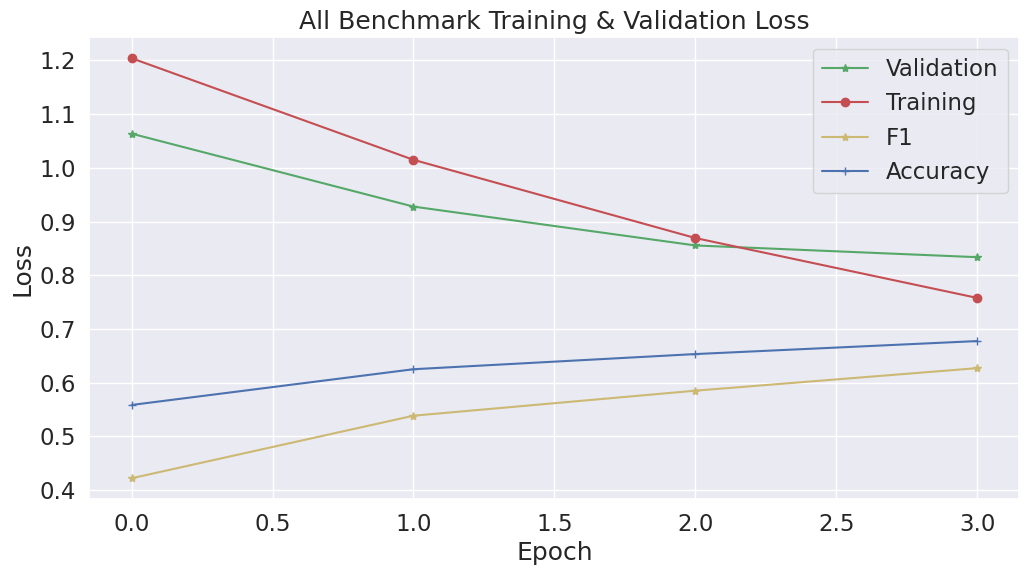

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

# Plot the learning curve.
plt.plot(val_loss, 'g-*', label= 'Validation')
plt.plot(train_loss, 'r-o', label= 'Training')

plt.plot(Macro_f1,'y-*', label='F1')
plt.plot(accuracy, 'b-+', label='Accuracy')


# Label the plot
plt.title("All Benchmark Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.show()

## **Prepare the Metrics**
During the training phase logits are built, from which the HugginFace transformer will deduce relations and predicted vectors. They will be compared with the labels and returned as framed metrics including *accuracy, precision, recall and f1-scores*

in **multiclass classification** the predicted vector is reached by assigning a 1 tot he highest logit and 0 to all others, using the softMax the class witht he highest probability will have the highest score.

in **multilabel classification** deduces the predicted vector by assigning 1 to all non-negative logits and 0 to all negative logits. >=0.5 probability belongs to the coressponding class.


In [31]:

# We can take a more detailed look at the training metrics by calculating the confusion matrix.
# To visualize the confusion matrix, we first need to get the predictions on the validation set.
# The predict() method of the Trainer class returns several useful objects we can use for evaluation.
preds_output = trainer.predict(text_encoded["val"])

In [32]:


# The output of the predict() method is a PredictionOutput object that contains
# arrays of predictions and label_ids, along with the metrics we passed to the trainer.
# For example, the metrics on the validation set can be accessed.
preds_output.metrics



{'test_loss': 0.8336167931556702,
 'test_accuracy': 0.6774193548387096,
 'test_f1': 0.627009563508502,
 'test_runtime': 0.37,
 'test_samples_per_second': 1340.625,
 'test_steps_per_second': 43.246}

In [33]:


# It also contains the raw predictions for each class.
# We can decode the predictions using np.argmax().
y_preds = np.argmax(preds_output.predictions, axis = 1)



In [34]:
# Model prediction metrics on the test set
preds_output = trainer.predict(text_encoded["test"])
preds_output.metrics

{'test_loss': 0.7778694033622742,
 'test_accuracy': 0.6868686868686869,
 'test_f1': 0.6395968319592518,
 'test_runtime': 0.4061,
 'test_samples_per_second': 1218.813,
 'test_steps_per_second': 39.396}

## Plot Confusion Matrix (*change*)

Text(0.5, 1.0, 'Multilingual Benchmark - Vanilla Model')

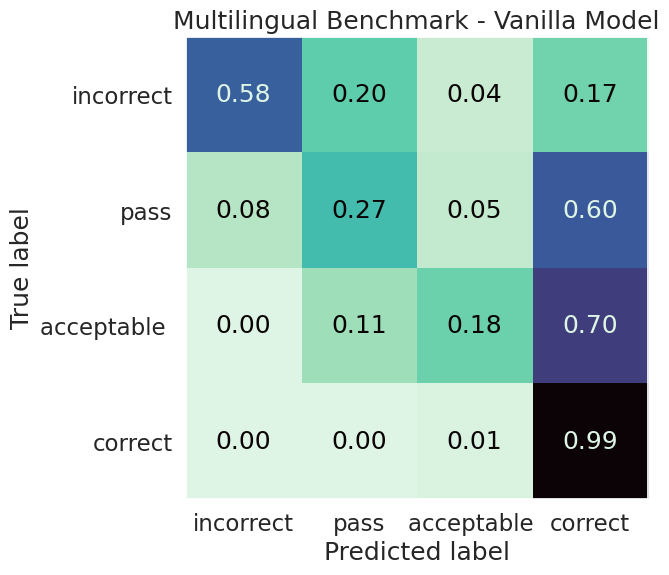

In [35]:
# With the predictions, we can plot the confusion matrix.
cm = confusion_matrix(text_encoded["val"]['label'], y_preds, normalize = "true")

labels = ['incorrect','pass', 'acceptable ', 'correct']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
#disp.plot(cmap = "YlGnBu", values_format = ".2f", colorbar = False)
#disp.plot(cmap = "crest", values_format = ".2f", colorbar = False)
disp.plot(cmap = "mako_r", values_format = ".2f", colorbar = False)
#disp.plot(cmap = "OrRd", values_format = ".2f", colorbar = False)

plt.grid(False)

plt.title("Multilingual Benchmark - Vanilla Model")

## Save and share the model (*change*)

In [36]:

# Since we specified the option "load_best_model_at_end = True" in the training argument,
# the current model is the best one. We now want to save the model locally.
# Note: We can still use the pre-trained model's tokenizer since we did not modify it,
# but for illustration purpose, we save the tokenizer as well.
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('augmented_multiclass/tokenizer_config.json',
 'augmented_multiclass/special_tokens_map.json',
 'augmented_multiclass/vocab.txt',
 'augmented_multiclass/added_tokens.json',
 'augmented_multiclass/tokenizer.json')

In [37]:
# Because we choose not to push our model to the Hub, we will load the locally-saved best model here.
from transformers import pipeline
classifier = pipeline(
  "text-classification",
  model = os.path.join(output_dir),
  tokenizer = os.path.join(output_dir))
#Else use this below, where you just call the model and the tokenizer


#model = model_class.from_pretrained(output_dir)
#tokenizer = tokenizer_class.from_pretrained(output_dir)
#model.to(device)

In [ ]:
# Then we can test the pipeline with a sample sentence (or a sentence from our test set).
Farsi_text = "kudum kɛtɑb rɔ ɛntɛxɑb kærd?"

preds_Farsi = classifier(Farsi_text, top_k=None)

print('\nThe predictions for the sentence "kudum kɛtɑb rɔ ɛntɛxɑb kærd?" are:\n')
preds_Farsi


The predictions for the sentence "kudum kɛtɑb rɔ ɛntɛxɑb kærd?" are:



[{'label': 'correct', 'score': 0.9246983528137207},
 {'label': 'acceptable ', 'score': 0.06100202724337578},
 {'label': 'pass', 'score': 0.01119774766266346},
 {'label': 'incorrect', 'score': 0.0031018634326756}]

## Sample Sentences (*change*)

In [38]:
input_texts = [
               "Who have they seen near the steps?",
               "He should wash the baby that the child is patting.",
               "What did they find yesterday in the snow?",
               "The books...",
               "The children will if they sleep.",
               "They are eating the bananas in the dark.",
               "οι οδηγοί άφησαν τους επιβάτες των λεωφορείων στην επόμενη στάση",
               "ο χορευτής πήρε την ομπρέλα του και περπάτησε στη δυνατή βροχή",
               "ο προπονητής δεν να κερδίσει η ομάδα του σήμερα",
               "η γιαγιά ότι σε αυτά τα μέρη πετούσαν περίεργα πουλιά",
               "dɔxtær-i kɛ tɔ dust dɑri xɑhærɛ mænɛ",
               "kudum kɛtɑb rɔ ɛntɛxɑb kærd?",
               "væqti lɛbæs pushidam mikhoram",
               "kahli",
               "Es war eine lange dunkle Nacht.",
               "È stata una lunga notte buia",
               "یہ ایک لمبی سیاہ رات تھی",
               "C'était une longue nuit sombre",
               "لقد كانت ليلة مظلمة طويلة",
               "أحب المدرسة"
               ]
print("All Benchmark - Sample Sentence Classification")
for text in input_texts:
  prediction = classifier(text)
  print('the sentence: "', text,'" is:', prediction)

All Benchmark - Sample Sentence Classification
the sentence: " Who have they seen near the steps? " is: [{'label': 'correct', 'score': 0.8413427472114563}]
the sentence: " He should wash the baby that the child is patting. " is: [{'label': 'acceptable ', 'score': 0.4894869327545166}]
the sentence: " What did they find yesterday in the snow? " is: [{'label': 'correct', 'score': 0.8902005553245544}]
the sentence: " The books... " is: [{'label': 'incorrect', 'score': 0.7003532648086548}]
the sentence: " The children will if they sleep. " is: [{'label': 'correct', 'score': 0.5242088437080383}]
the sentence: " They are eating the bananas in the dark. " is: [{'label': 'correct', 'score': 0.7836713790893555}]
the sentence: " οι οδηγοί άφησαν τους επιβάτες των λεωφορείων στην επόμενη στάση " is: [{'label': 'correct', 'score': 0.5522050261497498}]
the sentence: " ο χορευτής πήρε την ομπρέλα του και περπάτησε στη δυνατή βροχή " is: [{'label': 'correct', 'score': 0.6676234006881714}]
the sentence

# **MCC**

**Data Perparation**

We'll need to apply all of the same steps we did for the training dataset:

In [50]:
import torch

# It there's a GPU available...
if torch.cuda.is_available():


  # Tell PyTorch to use the GPU.
  device = torch.device("cuda")

  print('There are %d GPU(s) available.' % torch.cuda.device_count())

  print('We will use the GPU:' , torch.cuda.get_device_name(0))

# If not
else:
  print('No GPU is available, using CPU instead.')
  device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [51]:
# Create sentence and label lists
responses =All_text.text.values
scores = All_text.label.values

In [52]:
from torch.utils.data import TensorDataset

In [53]:
# Tokenize all of the sentences and map the tokens to their word IDs
input_ids = []
attention_masks = []

# For every sentence...
for reponse in responses:
  # Encode_plus will...
  # 1) Tokenize the sentence
  # 2) Prepend the '[CLS]' token to the start.
  # 3) Append the '[SEP]' token to the send.
  # 4) Map the tokens ti their IDs.
  # 5) Pad or truncate the sentence to 'max_length'
  # 6) Create attention masks for [PAD] tokens.
  encoded_dict = tokenizer.encode_plus(
      reponse,                           # Sentence to encode.
      add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
      max_length = 44,                # Pad & truncate all sentences.--> FOR GREEK USE >44
      pad_to_max_length = True,
      return_attention_mask = True,   # Construct attn. masks.
      return_tensors = 'pt',          # Return pytorch tensors.
  )

  # Add the encoded sentence to the list.
  input_ids.append(encoded_dict['input_ids'])

  # Attention_masks differentiate relevant information from padding
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
scores = torch.tensor(scores)

# Set the batch size
batch_size = 256

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, scores)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [54]:
# Predicitons on the Test Set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_scores = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_scores = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  score_ids = b_scores.to('cpu').numpy()

  #remove nan from score_ids
  #score_ids = score_ids[~np.isnan(score_ids)]

  # Store predictions and true labels
  predictions.append(logits)
  true_scores.append(score_ids)

print('    DONE.')

Predicting labels for 3,301 test sentences...
    DONE.


In [55]:
print('Positive samples: %d of %d (%.2f%%)' % (df_test.CELF_SCORING.sum(),
                                               len(df_test.CELF_SCORING),
                                                (df_test.CELF_SCORING.sum() / len(df_test.CELF_SCORING)* 100.0)))

Positive samples: 6791 of 3301 (205.73%)


In [56]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating MCC for each batch...')

# For each batch...
for i in range(len(true_scores)):
    # The predictions for this batch are a 2-column ndarray (one column for "0"
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_scores_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.
    #if true_scores[i] != "nan"



    matthews = matthews_corrcoef(true_scores[i], pred_scores_i)
    matthews_set.append(matthews)

print('DONE')

Calculating MCC for each batch...
DONE


In [57]:

# Combine all results across all batches
flat_predictions = np.concatenate(predictions, axis = 0)

# For each sample, pick the label (0 or 1) with the higher score,
flat_predictions = np.argmax(flat_predictions, axis = 1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_scores = np.concatenate(true_scores, axis = 0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_scores, flat_predictions)


print('Total MCC: %.3f' % mcc)


Total MCC: 0.520


## **Total MCC and Graph** (Vanilla) (*change*)


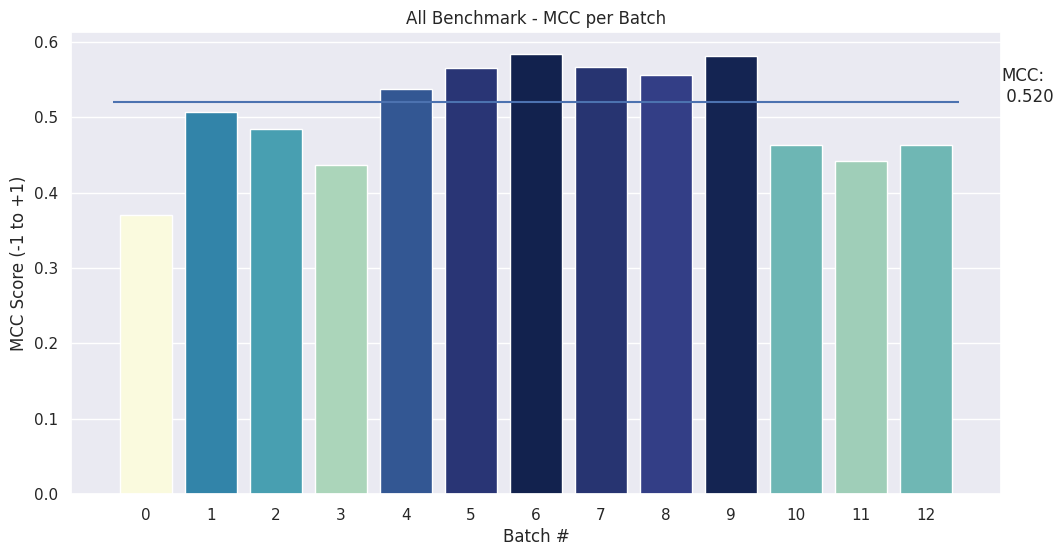

In [58]:
# Creat a barplot of the batches' MCC scores
#sns.color_palette("Set2")
#sns.color_palette("tab10")
sns.set(color_codes=True)

ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, hue = matthews_set,
#                palette="OrRd", legend=False)
                palette="YlGnBu", legend=False)
#                palette="mako_r", legend=False)
#                palette= "crest", legend=False)


ax.hlines(mcc, *ax.get_xlim())
ax.annotate(f'MCC:\n {mcc:.3f}', xy=(ax.get_xlim()[1],mcc))

plt.title('All Benchmark - MCC per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')
plt.show()

# **Text Augmentation**


- Here we can initialize the first of three different **Text-
Augmentation strategies**.

In [59]:
# Synonym Augmentation
aug_syn = naw.SynonymAug(
    aug_src= 'wordnet',
    aug_max = 3)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [60]:
## Initiate the contextual word embeddings (BERT, DistilBERT, RoBERTA or XLNet) augmentation
aug_emb = naw.ContextualWordEmbsAug(
  # Other models include 'distilbert-base-uncased', 'roberta-base', etc.
  model_path = PATH,
  # You can also choose "insert"
  action = "substitute",
  # Use GPU
  device = 'cuda'
  )

In [61]:
# Initiate the back translation augmentation
aug_bt = naw.BackTranslationAug(
  # Translate Farsi to English
  from_model_name = "Helsinki-NLP/opus-mt-en-iir",
  # Translate English back to Farsi
  to_model_name = "Helsinki-NLP/opus-mt-iir-en",
  # Use GPU
  device = 'cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/928k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.93M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/928k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

## Evaluate Augmentation (*change*)




In [62]:
# Create a function to evaluate the text augmentation on the model performance
# on thes set.

def evaluate_aug(aug_strategy, n, train, ds_val, ds_test):

  # Create two lists to store the augmented sentences and their corresponding labels
  augmented_text = []
  augmented_text_labels = []
  # Loop through the train set to creat augmented sentences
  # We can set the number of augmented sentences we want
  # to create per original sentence.
  for i in train.index:
    if aug_strategy == "synonym":
      lst_augment = aug_syn.augment(train['text'].loc[i], n = n)
    elif aug_strategy == 'embedding':
      lst_augment = aug_emb.augment(train['text'].loc[i], n = n)
    else:
      lst_augment = aug_bt.augment(train['text'].loc[i], n = n)
    for augment in lst_augment:
      augmented_text.append(augment)
      augmented_text_labels.append(train['label'].loc[i])

  # Zip the two lists into a list of tuples
  augmented_text_labels = list(zip(augmented_text, augmented_text_labels))

  # Convert the list of tuples to a Pandas Dataframe.
  ds_augmented_text_labels = pd.DataFrame(
    augmented_text_labels, columns = ['text', 'label'])

  # Vertically concat the train set with the augmented texts
  train_augmented = pd.concat([train, ds_augmented_text_labels], axis = 0)

  # Convert the DataFrame to a Dataset (Aparche Arrow format)
  dset_train_augmented = Dataset.from_pandas(train_augmented)

  # Gather train, val, and test Datasets to have a single DatasetDict,
  # which can be manipulated together
  text_augmented = DatasetDict({
    'train': dset_train_augmented,
    'val': ds_val,
    'test': ds_test})
  text_augmented = text_augmented.remove_columns(["__index_level_0__"])

  # Tokenize the sentences dataset
  text_augmented_encoded = text_augmented.map(
    tokenize,
    batched = True,
    batch_size = None)

  # Remove the text column from the encoded DatasetDict because the model does not use it.
  text_augmented_encoded = text_augmented_encoded.remove_columns(['text'])

  # Since the model expects tensors as inputs,
  # we will convert the input_ids and attention_mask columns to the "torch" format.
  text_augmented_encoded.set_format(
    "torch", columns = ["input_ids", "attention_mask", "label"])

   # Define the trainer
  trainer = Trainer(
    # Model
    model = model,
    # Training argument
    args = training_args,
    # Metrics (f1 score and accuracy)
    compute_metrics = compute_metrics,
    # Train and val Datasets
    train_dataset = text_augmented_encoded["train"],
    eval_dataset = text_augmented_encoded["val"],
    # Tokenizer
    tokenizer = tokenizer)

  # Clean up the memory using the garbage cleaner
  gc.collect()
  torch.cuda.empty_cache()

  # Start the training process
  trainer.train()

  # Use the model to predict the test set
  preds_output = trainer.predict(text_encoded["test"])
  print(preds_output.metrics)

  model.save_pretrained(output_dir)
  tokenizer.save_pretrained(output_dir)

  # Remove all elements from the lists
  augmented_text.clear()
  augmented_text_labels.clear()

In [63]:
tokenizer.model_max_length

1000000000000000019884624838656

# **SYNONYMS**

In [64]:
# Evaluate the synonym text augmentation
score_synonym = evaluate_aug(
  aug_strategy = 'synonym',
  n = 2,
  train = train,
  ds_val = ds_val,
  ds_test = ds_test)
print(score_synonym)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Map:   0%|          | 0/6930 [00:00<?, ? examples/s]

Map:   0%|          | 0/496 [00:00<?, ? examples/s]

Map:   0%|          | 0/495 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.763200,0.889138,0.679435,0.630514
2,0.542300,0.753047,0.756048,0.734841
3,0.341900,0.882147,0.760081,0.736588
4,0.256400,0.899979,0.754032,0.730424


{'test_loss': 0.7051576375961304, 'test_accuracy': 0.7535353535353535, 'test_f1': 0.730817494312257, 'test_runtime': 0.3816, 'test_samples_per_second': 1297.138, 'test_steps_per_second': 41.928}
None


## Classifier Pipeline (*change*)


In [66]:
# Because we choose not to push our model to the Hub, we will load the locally-saved best model here.
from transformers import pipeline
classifier = pipeline(
  "text-classification",
  model = os.path.join(output_dir),
  tokenizer = os.path.join(output_dir))
#Else use this below, where you just call the model and the tokenizer


#model = model_class.from_pretrained(output_dir)
#tokenizer = tokenizer_class.from_pretrained(output_dir)
#model.to(device)

## Sample Sentences (*change*)

In [67]:
input_texts = [
               "Who have they seen near the steps?",
               "He should wash the baby that the child is patting.",
               "What did they find yesterday in the snow?",
               "The books...",
               "The children will if they sleep.",
               "They are eating the bananas in the dark.",
               "οι οδηγοί άφησαν τους επιβάτες των λεωφορείων στην επόμενη στάση",
               "ο χορευτής πήρε την ομπρέλα του και περπάτησε στη δυνατή βροχή",
               "ο προπονητής δεν να κερδίσει η ομάδα του σήμερα",
               "η γιαγιά ότι σε αυτά τα μέρη πετούσαν περίεργα πουλιά",
               "dɔxtær-i kɛ tɔ dust dɑri xɑhærɛ mænɛ",
               "kudum kɛtɑb rɔ ɛntɛxɑb kærd?",
               "væqti lɛbæs pushidam mikhoram",
               "kahli",
               "Es war eine lange dunkle Nacht.",
               "È stata una lunga notte buia",
               "یہ ایک لمبی سیاہ رات تھی",
               "C'était une longue nuit sombre",
               "لقد كانت ليلة مظلمة طويلة",
               "أحب المدرسة"
               ]
print("All Shallow - SYNONYM AUGMENTED Sample Sentence Classification")
for text in input_texts:
  prediction = classifier(text)
  print('the sentence: "', text,'" is:', prediction)

All Shallow - SYNONYM AUGMENTED Sample Sentence Classification
the sentence: " Who have they seen near the steps? " is: [{'label': 'correct', 'score': 0.9462884664535522}]
the sentence: " He should wash the baby that the child is patting. " is: [{'label': 'correct', 'score': 0.7033753991127014}]
the sentence: " What did they find yesterday in the snow? " is: [{'label': 'correct', 'score': 0.9679465293884277}]
the sentence: " The books... " is: [{'label': 'incorrect', 'score': 0.9628216028213501}]
the sentence: " The children will if they sleep. " is: [{'label': 'pass', 'score': 0.8098134994506836}]
the sentence: " They are eating the bananas in the dark. " is: [{'label': 'correct', 'score': 0.9321122169494629}]
the sentence: " οι οδηγοί άφησαν τους επιβάτες των λεωφορείων στην επόμενη στάση " is: [{'label': 'correct', 'score': 0.946000337600708}]
the sentence: " ο χορευτής πήρε την ομπρέλα του και περπάτησε στη δυνατή βροχή " is: [{'label': 'correct', 'score': 0.9734042286872864}]
the 

## **MCC** (Synonyms)

**Data Perparation**

We'll need to apply all of the same steps we did for the training dataset:

In [68]:
import torch

# It there's a GPU available...
if torch.cuda.is_available():


  # Tell PyTorch to use the GPU.
  device = torch.device("cuda")

  print('There are %d GPU(s) available.' % torch.cuda.device_count())

  print('We will use the GPU:' , torch.cuda.get_device_name(0))

# If not
else:
  print('No GPU is available, using CPU instead.')
  device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [71]:
import pandas as pd

# Load the dataset into a Pandas dataframe. This is where the data from the second/ Third language comes.
#df_test = pd.read_csv("/content/drive/MyDrive/data/farsi/farsiCELF.csv", on_bad_lines='skip', encoding='ISO-8859-1')
df_test = pd.read_csv("/content/drive/MyDrive/data/multilingual/allDataCELF.csv",  keep_default_na=False, sep = ";")
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

df_test.columns

Number of test sentences: 3,301



Index(['TARGET', 'RESPONSE', 'AUTO_SCORING', 'TOLD_SCORING', 'CELF_SCORING'], dtype='object')

In [ ]:
df_test.head(5)

,TARGET,RESPONSE,AUTO_SCORING,TOLD_SCORING
0,They are eating the bananas in the park.,They are eating the banana in the park.,1,0
1,What did the princess buy last month?,What did the princess buy last month?,0,1
2,He was kicked in the leg by the donkey.,He was kicking in the leg by the donkeys.,2,0
3,He will feed the cow before he waters the plants.,He will feed the cow before he water the plant.,2,0
4,The children enjoyed the cake that they tasted.,The children enjoyed the cake that they tasted.,0,1


In [72]:
# Create sentence and label lists
responses = df_test.RESPONSE.values
scores = df_test.CELF_SCORING.values

In [73]:
from torch.utils.data import TensorDataset

In [74]:
# Tokenize all of the sentences and map the tokens to their word IDs
input_ids = []
attention_masks = []

# For every sentence...
for reponse in responses:
  # Encode_plus will...
  # 1) Tokenize the sentence
  # 2) Prepend the '[CLS]' token to the start.
  # 3) Append the '[SEP]' token to the send.
  # 4) Map the tokens ti their IDs.
  # 5) Pad or truncate the sentence to 'max_length'
  # 6) Create attention masks for [PAD] tokens.
  encoded_dict = tokenizer.encode_plus(
      reponse,                           # Sentence to encode.
      add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
      max_length = 44,                # Pad & truncate all sentences.--> FOR GREEK USE >44
      pad_to_max_length = True,
      return_attention_mask = True,   # Construct attn. masks.
      return_tensors = 'pt',          # Return pytorch tensors.
  )

  # Add the encoded sentence to the list.
  input_ids.append(encoded_dict['input_ids'])

  # Attention_masks differentiate relevant information from padding
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
scores = torch.tensor(scores)

# Set the batch size
batch_size = 256

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, scores)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [75]:
# Predicitons on the Test Set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_scores = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_scores = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  score_ids = b_scores.to('cpu').numpy()

  #remove nan from score_ids
  #score_ids = score_ids[~np.isnan(score_ids)]

  # Store predictions and true labels
  predictions.append(logits)
  true_scores.append(score_ids)

print('    DONE.')

Predicting labels for 3,301 test sentences...
    DONE.


In [77]:
print('Positive samples: %d of %d (%.2f%%)' % (df_test.CELF_SCORING.sum(),
                                               len(df_test.CELF_SCORING),
                                                (df_test.CELF_SCORING.sum() / len(df_test.CELF_SCORING)* 100.0)))

Positive samples: 6791 of 3301 (205.73%)


In [78]:
matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating MCC for each batch...')

# For each batch...
for i in range(len(true_scores)):
    # The predictions for this batch are a 2-column ndarray (one column for "0"
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_scores_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.
    #if true_scores[i] != "nan"



    matthews = matthews_corrcoef(true_scores[i], pred_scores_i)
    matthews_set.append(matthews)

print('DONE')

Calculating MCC for each batch...
DONE


In [79]:

# Combine all results across all batches
flat_predictions = np.concatenate(predictions, axis = 0)

# For each sample, pick the label (0 or 1) with the higher score,
flat_predictions = np.argmax(flat_predictions, axis = 1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_scores = np.concatenate(true_scores, axis = 0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_scores, flat_predictions)


print('Total MCC: %.3f' % mcc)


Total MCC: 0.731


## **Total MCC and Graph** (Synonyms) (*change*)


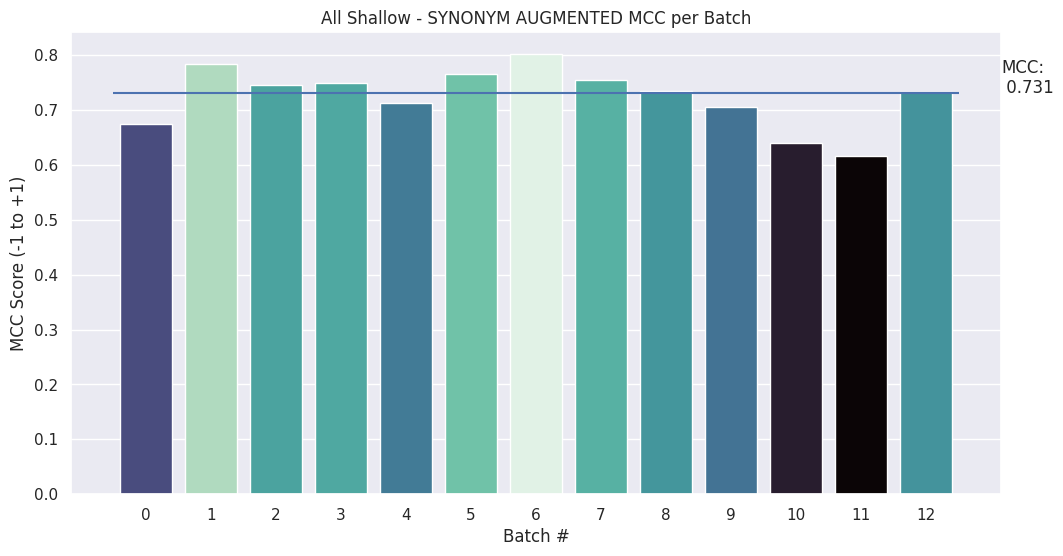

In [80]:
# Creat a barplot of the batches' MCC scores
sns.set(color_codes=True)

ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, hue = matthews_set,
#                palette="crest", legend=False)
                palette="mako", legend=False)


ax.hlines(mcc, *ax.get_xlim())
ax.annotate(f'MCC:\n {mcc:.3f}', xy=(ax.get_xlim()[1],mcc))

plt.title('All Shallow - SYNONYM AUGMENTED MCC per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')
plt.show()

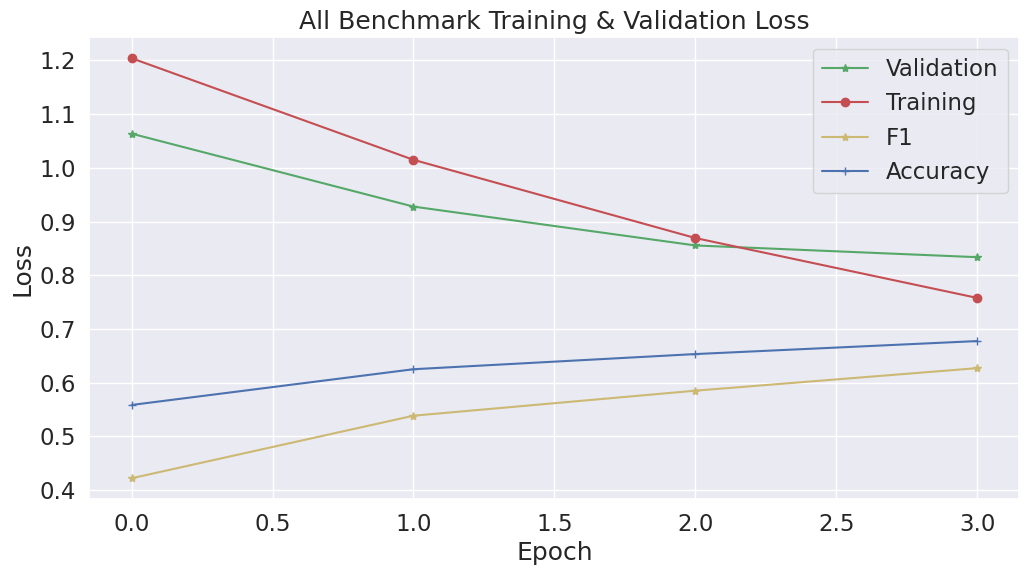

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

# Plot the learning curve.
plt.plot(val_loss, 'g-*', label= 'Validation')
plt.plot(train_loss, 'r-o', label= 'Training')

plt.plot(Macro_f1,'y-*', label='F1')
plt.plot(accuracy, 'b-+', label='Accuracy')


# Label the plot
plt.title("All Benchmark Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.show()

## **Prepare the Metrics**
During the training phase logits are built, from which the HugginFace transformer will deduce relations and predicted vectors. They will be compared with the labels and returned as framed metrics including *accuracy, precision, recall and f1-scores*

in **multiclass classification** the predicted vector is reached by assigning a 1 tot he highest logit and 0 to all others, using the softMax the class witht he highest probability will have the highest score.

in **multilabel classification** deduces the predicted vector by assigning 1 to all non-negative logits and 0 to all negative logits. >=0.5 probability belongs to the coressponding class.


In [82]:

# We can take a more detailed look at the training metrics by calculating the confusion matrix.
# To visualize the confusion matrix, we first need to get the predictions on the validation set.
# The predict() method of the Trainer class returns several useful objects we can use for evaluation.
preds_output = trainer.predict(text_encoded["val"])

In [83]:


# The output of the predict() method is a PredictionOutput object that contains
# arrays of predictions and label_ids, along with the metrics we passed to the trainer.
# For example, the metrics on the validation set can be accessed.
preds_output.metrics



{'test_loss': 0.7530469298362732,
 'test_accuracy': 0.7560483870967742,
 'test_f1': 0.7348410651746429,
 'test_runtime': 0.347,
 'test_samples_per_second': 1429.298,
 'test_steps_per_second': 46.106}

In [84]:


# It also contains the raw predictions for each class.
# We can decode the predictions using np.argmax().
y_preds = np.argmax(preds_output.predictions, axis = 1)



In [85]:
# Model prediction metrics on the test set
preds_output = trainer.predict(text_encoded["test"])
preds_output.metrics

{'test_loss': 0.7051576375961304,
 'test_accuracy': 0.7535353535353535,
 'test_f1': 0.730817494312257,
 'test_runtime': 0.4141,
 'test_samples_per_second': 1195.238,
 'test_steps_per_second': 38.634}

## Plot Synonym Confusion Matrix (*change*)

Text(0.5, 1.0, 'Multilingual Benchmark - Vanilla Model')

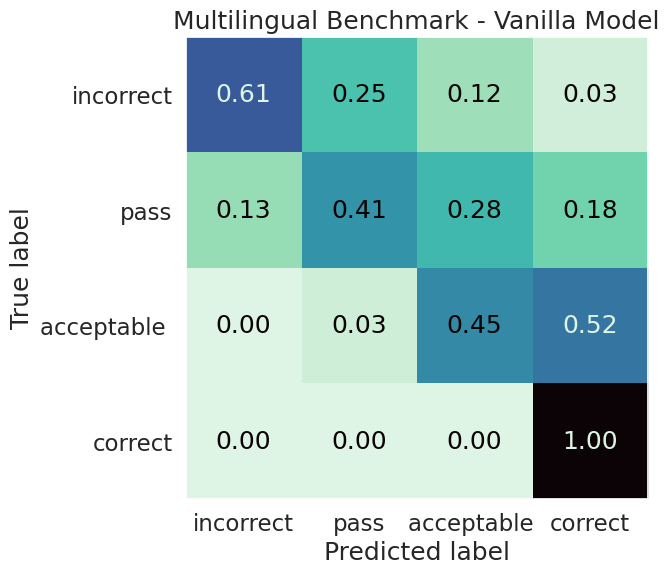

In [86]:
# With the predictions, we can plot the confusion matrix.
cm = confusion_matrix(text_encoded["val"]['label'], y_preds, normalize = "true")

labels = ['incorrect','pass', 'acceptable ', 'correct']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
#disp.plot(cmap = "YlGnBu", values_format = ".2f", colorbar = False)
#disp.plot(cmap = "crest", values_format = ".2f", colorbar = False)
disp.plot(cmap = "mako_r", values_format = ".2f", colorbar = False)
#disp.plot(cmap = "OrRd", values_format = ".2f", colorbar = False)

plt.grid(False)

plt.title("Multilingual Benchmark - Vanilla Model")

# **CONTEXTUAL EMBEDDINGS**

In [87]:
# Evaluate the embedding text augmentation
score_embedding = evaluate_aug(
  aug_strategy = 'embedding',
  n = 2,
  train = train,
  ds_val = ds_val,
  ds_test = ds_test)
print(score_embedding)

Map:   0%|          | 0/6930 [00:00<?, ? examples/s]

Map:   0%|          | 0/496 [00:00<?, ? examples/s]

Map:   0%|          | 0/495 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.874700,0.836732,0.695565,0.654003
2,0.728800,0.764652,0.758065,0.737520
3,0.607800,0.833259,0.758065,0.734869
4,0.533800,0.863473,0.768145,0.746631


{'test_loss': 0.6077647805213928, 'test_accuracy': 0.806060606060606, 'test_f1': 0.7925176340683334, 'test_runtime': 0.4027, 'test_samples_per_second': 1229.194, 'test_steps_per_second': 39.732}
None


## Classifier Pipeline (*change*)


In [88]:
# Because we choose not to push our model to the Hub, we will load the locally-saved best model here.
from transformers import pipeline
classifier = pipeline(
  "text-classification",
  model = os.path.join(output_dir),
  tokenizer = os.path.join(output_dir))
#Else use this below, where you just call the model and the tokenizer


#model = model_class.from_pretrained(output_dir)
#tokenizer = tokenizer_class.from_pretrained(output_dir)
#model.to(device)



## Sample Sentences (*change*)

In [89]:
input_texts = [
               "Who have they seen near the steps?",
               "He should wash the baby that the child is patting.",
               "What did they find yesterday in the snow?",
               "The books...",
               "The children will if they sleep.",
               "They are eating the bananas in the dark.",
               "οι οδηγοί άφησαν τους επιβάτες των λεωφορείων στην επόμενη στάση",
               "ο χορευτής πήρε την ομπρέλα του και περπάτησε στη δυνατή βροχή",
               "ο προπονητής δεν να κερδίσει η ομάδα του σήμερα",
               "η γιαγιά ότι σε αυτά τα μέρη πετούσαν περίεργα πουλιά",
               "dɔxtær-i kɛ tɔ dust dɑri xɑhærɛ mænɛ",
               "kudum kɛtɑb rɔ ɛntɛxɑb kærd?",
               "væqti lɛbæs pushidam mikhoram",
               "kahli",
               "Es war eine lange dunkle Nacht.",
               "È stata una lunga notte buia",
               "یہ ایک لمبی سیاہ رات تھی",
               "C'était une longue nuit sombre",
               "لقد كانت ليلة مظلمة طويلة",
               "أحب المدرسة"
               ]
print("Multiclass Vanilla - CONTEXTUAL EMBEDDINGS AUGMENTED Sample Sentence Classification")
for text in input_texts:
  prediction = classifier(text)
  print('the sentence: "', text,'" is:', prediction)

Multiclass Vanilla - CONTEXTUAL EMBEDDINGS AUGMENTED Sample Sentence Classification
the sentence: " Who have they seen near the steps? " is: [{'label': 'correct', 'score': 0.9038458466529846}]
the sentence: " He should wash the baby that the child is patting. " is: [{'label': 'correct', 'score': 0.6555657982826233}]
the sentence: " What did they find yesterday in the snow? " is: [{'label': 'correct', 'score': 0.9687873125076294}]
the sentence: " The books... " is: [{'label': 'incorrect', 'score': 0.9827722907066345}]
the sentence: " The children will if they sleep. " is: [{'label': 'acceptable ', 'score': 0.5835427641868591}]
the sentence: " They are eating the bananas in the dark. " is: [{'label': 'correct', 'score': 0.7385417222976685}]
the sentence: " οι οδηγοί άφησαν τους επιβάτες των λεωφορείων στην επόμενη στάση " is: [{'label': 'correct', 'score': 0.9663758277893066}]
the sentence: " ο χορευτής πήρε την ομπρέλα του και περπάτησε στη δυνατή βροχή " is: [{'label': 'correct', 'scor

## **MCC** (Contextual Embeddings)

**Data Perparation**

We'll need to apply all of the same steps we did for the training dataset:

In [91]:
import torch

# It there's a GPU available...
if torch.cuda.is_available():


  # Tell PyTorch to use the GPU.
  device = torch.device("cuda")

  print('There are %d GPU(s) available.' % torch.cuda.device_count())

  print('We will use the GPU:' , torch.cuda.get_device_name(0))

# If not
else:
  print('No GPU is available, using CPU instead.')
  device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [92]:
import pandas as pd

# Load the dataset into a Pandas dataframe. This is where the data from the second/ Third language comes.
#df_test = pd.read_csv("/content/drive/MyDrive/data/farsi/farsiCELF.csv", on_bad_lines='skip', encoding='ISO-8859-1')
df_test = pd.read_csv("/content/drive/MyDrive/data/multilingual/allDataCELF.csv",  keep_default_na=False, sep = ";")
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

df_test.columns

Number of test sentences: 3,301



Index(['TARGET', 'RESPONSE', 'AUTO_SCORING', 'TOLD_SCORING', 'CELF_SCORING'], dtype='object')

In [93]:
# Create sentence and label lists
responses = df_test.RESPONSE.values
scores = df_test.CELF_SCORING.values

In [94]:
from torch.utils.data import TensorDataset

In [95]:
# Tokenize all of the sentences and map the tokens to their word IDs
input_ids = []
attention_masks = []

# For every sentence...
for reponse in responses:
  # Encode_plus will...
  # 1) Tokenize the sentence
  # 2) Prepend the '[CLS]' token to the start.
  # 3) Append the '[SEP]' token to the send.
  # 4) Map the tokens ti their IDs.
  # 5) Pad or truncate the sentence to 'max_length'
  # 6) Create attention masks for [PAD] tokens.
  encoded_dict = tokenizer.encode_plus(
      reponse,                           # Sentence to encode.
      add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
      max_length = 44,                # Pad & truncate all sentences.--> FOR GREEK USE >44
      pad_to_max_length = True,
      return_attention_mask = True,   # Construct attn. masks.
      return_tensors = 'pt',          # Return pytorch tensors.
  )

  # Add the encoded sentence to the list.
  input_ids.append(encoded_dict['input_ids'])

  # Attention_masks differentiate relevant information from padding
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
scores = torch.tensor(scores)

# Set the batch size
batch_size = 256

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, scores)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [96]:
# Predicitons on the Test Set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_scores = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_scores = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  score_ids = b_scores.to('cpu').numpy()

  #remove nan from score_ids
  #score_ids = score_ids[~np.isnan(score_ids)]

  # Store predictions and true labels
  predictions.append(logits)
  true_scores.append(score_ids)

print('    DONE.')

Predicting labels for 3,301 test sentences...
    DONE.


In [97]:
print('Positive samples: %d of %d (%.2f%%)' % (df_test.CELF_SCORING.sum(),
                                               len(df_test.CELF_SCORING),
                                                (df_test.CELF_SCORING.sum() / len(df_test.CELF_SCORING)* 100.0)))

Positive samples: 6791 of 3301 (205.73%)


In [98]:
matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating MCC for each batch...')

# For each batch...
for i in range(len(true_scores)):
    # The predictions for this batch are a 2-column ndarray (one column for "0"
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_scores_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.
    #if true_scores[i] != "nan"



    matthews = matthews_corrcoef(true_scores[i], pred_scores_i)
    matthews_set.append(matthews)

print('DONE')

Calculating MCC for each batch...
DONE


In [99]:

# Combine all results across all batches
flat_predictions = np.concatenate(predictions, axis = 0)

# For each sample, pick the label (0 or 1) with the higher score,
flat_predictions = np.argmax(flat_predictions, axis = 1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_scores = np.concatenate(true_scores, axis = 0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_scores, flat_predictions)


print('Total MCC: %.3f' % mcc)


Total MCC: 0.801


## **Total MCC and Graph** (Contextual Embeddings) (*change*)




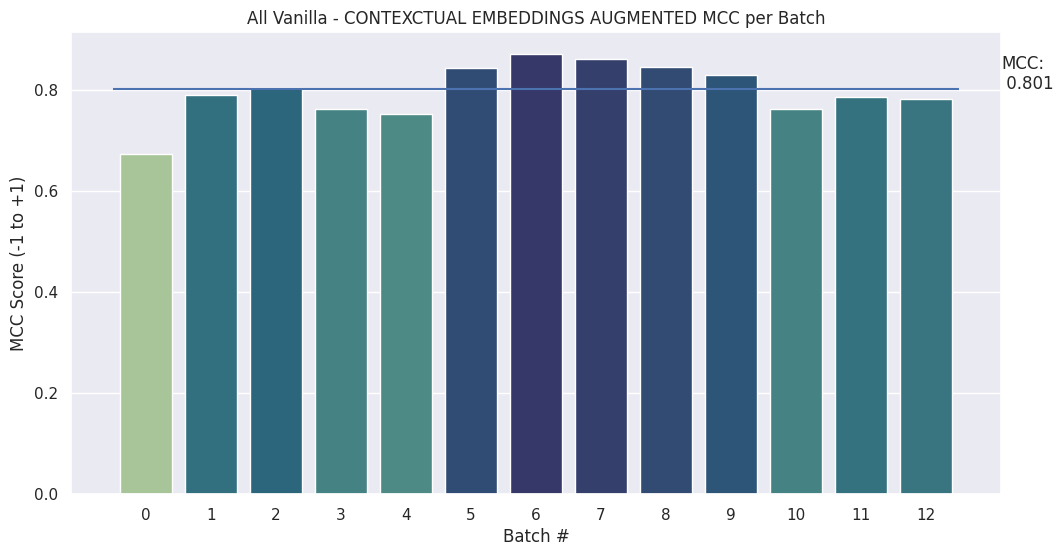

In [100]:
# Creat a barplot of the batches' MCC scores
sns.set(color_codes=True)

ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, hue = matthews_set,
                palette="crest", legend=False)
#                palette="mako", legend=False)


ax.hlines(mcc, *ax.get_xlim())
ax.annotate(f'MCC:\n {mcc:.3f}', xy=(ax.get_xlim()[1],mcc))

plt.title('All Vanilla - CONTEXCTUAL EMBEDDINGS AUGMENTED MCC per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')
plt.show()

## **Prepare the Metrics**
During the training phase logits are built, from which the HugginFace transformer will deduce relations and predicted vectors. They will be compared with the labels and returned as framed metrics including *accuracy, precision, recall and f1-scores*

in **multiclass classification** the predicted vector is reached by assigning a 1 tot he highest logit and 0 to all others, using the softMax the class witht he highest probability will have the highest score.

in **multilabel classification** deduces the predicted vector by assigning 1 to all non-negative logits and 0 to all negative logits. >=0.5 probability belongs to the coressponding class.


In [101]:

# We can take a more detailed look at the training metrics by calculating the confusion matrix.
# To visualize the confusion matrix, we first need to get the predictions on the validation set.
# The predict() method of the Trainer class returns several useful objects we can use for evaluation.
preds_output = trainer.predict(text_encoded["val"])

In [102]:
# The output of the predict() method is a PredictionOutput object that contains
# arrays of predictions and label_ids, along with the metrics we passed to the trainer.
# For example, the metrics on the validation set can be accessed.
preds_output.metrics

{'test_loss': 0.7646524906158447,
 'test_accuracy': 0.7580645161290323,
 'test_f1': 0.7375202876244569,
 'test_runtime': 0.3515,
 'test_samples_per_second': 1411.128,
 'test_steps_per_second': 45.52}

In [103]:
# It also contains the raw predictions for each class.
# We can decode the predictions using np.argmax().
y_preds = np.argmax(preds_output.predictions, axis = 1)

In [104]:
# Model prediction metrics on the test set
preds_output = trainer.predict(text_encoded["test"])
preds_output.metrics

{'test_loss': 0.6077647805213928,
 'test_accuracy': 0.806060606060606,
 'test_f1': 0.7925176340683334,
 'test_runtime': 0.382,
 'test_samples_per_second': 1295.893,
 'test_steps_per_second': 41.887}

## Plot Context Embeddings Confusion Matrix (*change*)

Text(0.5, 1.0, 'Multilingual  Benchmark - Vanilla Context Embeddings Model')

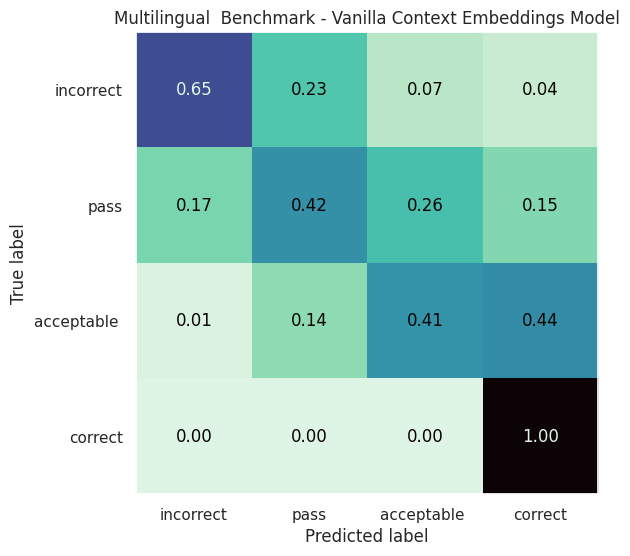

In [105]:
# With the predictions, we can plot the confusion matrix.
cm = confusion_matrix(text_encoded["val"]['label'], y_preds, normalize = "true")

labels = ['incorrect','pass', 'acceptable ', 'correct']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
#disp.plot(cmap = "YlGnBu", values_format = ".2f", colorbar = False)
#disp.plot(cmap = "crest", values_format = ".2f", colorbar = False)
disp.plot(cmap = "mako_r", values_format = ".2f", colorbar = False)
#disp.plot(cmap = "OrRd", values_format = ".2f", colorbar = False)

plt.grid(False)

plt.title("Multilingual  Benchmark - Vanilla Context Embeddings Model")

#**BACKTRANSLATION**

In [ ]:
# Evaluate the back translation text augmentation
score_backTransLation = evaluate_aug(
  aug_strategy = 'backtranslation',
  n = 2,
  train = train,
  ds_val = ds_val,
  ds_test = ds_test)
print(score_backTransLation)

Map:   0%|          | 0/2322 [00:00<?, ? examples/s]

Map:   0%|          | 0/330 [00:00<?, ? examples/s]

Map:   0%|          | 0/333 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.987100,1.173970,0.539394,0.378000
2,0.986400,1.172703,0.539394,0.378000
3,0.932400,1.172400,0.539394,0.378000
4,0.959600,1.171169,0.539394,0.378000


{'test_loss': 0.9917755722999573, 'test_accuracy': 0.6396396396396397, 'test_f1': 0.4990594990594991, 'test_runtime': 0.2275, 'test_samples_per_second': 1463.557, 'test_steps_per_second': 48.346}
None


## Classifier Pipeline (*change*)


In [ ]:
# Because we choose not to push our model to the Hub, we will load the locally-saved best model here.
from transformers import pipeline
classifier = pipeline(
  "text-classification",
  model = os.path.join("/content/drive/MyDrive/CNotebooks/Jan23/AUGAll"),
  tokenizer = os.path.join("/content/drive/MyDrive/CNotebooks/Jan23/AUGAll"))
#Else use this below, where you just call the model and the tokenizer


#model = model_class.from_pretrained(output_dir)
#tokenizer = tokenizer_class.from_pretrained(output_dir)
#model.to(device)

## Sample Sentences (*change*)

In [ ]:
input_texts = [
               "Who have they seen near the steps?",
               "He should wash the baby that the child is patting.",
               "What did they find yesterday in the snow?",
               "The books...",
               "The children will if they sleep.",
               "They are eating the bananas in the dark.",
               "οι οδηγοί άφησαν τους επιβάτες των λεωφορείων στην επόμενη στάση",
               "ο χορευτής πήρε την ομπρέλα του και περπάτησε στη δυνατή βροχή",
               "ο προπονητής δεν να κερδίσει η ομάδα του σήμερα",
               "η γιαγιά ότι σε αυτά τα μέρη πετούσαν περίεργα πουλιά",
               "dɔxtær-i kɛ tɔ dust dɑri xɑhærɛ mænɛ",
               "kudum kɛtɑb rɔ ɛntɛxɑb kærd?",
               "væqti lɛbæs pushidam mikhoram",
               "kahli",
               "Es war eine lange dunkle Nacht.",
               "È stata una lunga notte buia",
               "یہ ایک لمبی سیاہ رات تھی",
               "C'était une longue nuit sombre",
               "لقد كانت ليلة مظلمة طويلة",
               "أحب المدرسة"
               ]
print("All Shallow - BACKTRANSLATION AUGMENTED Sample Sentence Classification")
for text in input_texts:
  prediction = classifier(text)
  print('the sentence: "', text,'" is:', prediction)

FARSI Shallow - BACKTRANSLATION AUGMENTED Sample Sentence Classification
the sentence: " Who have they seen near the steps? " is: [{'label': 'acceptable ', 'score': 0.3953286111354828}]
the sentence: " He should wash the baby that the child is patting. " is: [{'label': 'pass', 'score': 0.5543384552001953}]
the sentence: " What did they find yesterday in the snow? " is: [{'label': 'acceptable ', 'score': 0.51777583360672}]
the sentence: " The books... " is: [{'label': 'incorrect', 'score': 0.5661503076553345}]
the sentence: " The children will if they sleep. " is: [{'label': 'incorrect', 'score': 0.4636662006378174}]
the sentence: " They are eating the bananas in the dark. " is: [{'label': 'pass', 'score': 0.46203696727752686}]
the sentence: " οι οδηγοί άφησαν τους επιβάτες των λεωφορείων στην επόμενη στάση " is: [{'label': 'pass', 'score': 0.4071755111217499}]
the sentence: " ο χορευτής πήρε την ομπρέλα του και περπάτησε στη δυνατή βροχή " is: [{'label': 'correct', 'score': 0.387661814

## **MCC** (Backtranslation)

**Data Perparation**

We'll need to apply all of the same steps we did for the training dataset:

In [ ]:
import torch

# It there's a GPU available...
if torch.cuda.is_available():


  # Tell PyTorch to use the GPU.
  device = torch.device("cuda")

  print('There are %d GPU(s) available.' % torch.cuda.device_count())

  print('We will use the GPU:' , torch.cuda.get_device_name(0))

# If not
else:
  print('No GPU is available, using CPU instead.')
  device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [ ]:
import pandas as pd

# Load the dataset into a Pandas dataframe. This is where the data from the second/ Third language comes.
#df_test = pd.read_csv("/content/drive/MyDrive/CNotebooks/ErrorTypesANON/New_3_SRep_all_data_withErrorTypesANON.csv", on_bad_lines='skip', encoding='ISO-8859-1')
df_test = pd.read_csv("/content/drive/MyDrive/CNotebooks/ErrorTypesANON/AllData.csv",  keep_default_na=False, sep = ";")
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

df_test.columns

Number of test sentences: 3,299



Index(['TARGET', 'RESPONSE', 'AUTO_SCORING', 'TOLD_SCORING'], dtype='object')

In [ ]:
df_test.head(5)

,TARGET,RESPONSE,AUTO_SCORING,TOLD_SCORING
0,They are eating the bananas in the park.,They are eating the banana in the park.,1,0
1,What did the princess buy last month?,What did the princess buy last month?,0,1
2,He was kicked in the leg by the donkey.,He was kicking in the leg by the donkeys.,2,0
3,He will feed the cow before he waters the plants.,He will feed the cow before he water the plant.,2,0
4,The children enjoyed the cake that they tasted.,The children enjoyed the cake that they tasted.,0,1


In [ ]:
# Create sentence and label lists
responses = df_test.RESPONSE.values
scores = df_test.TOLD_SCORING.values

In [ ]:
from torch.utils.data import TensorDataset

In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs
input_ids = []
attention_masks = []

# For every sentence...
for reponse in responses:
  # Encode_plus will...
  # 1) Tokenize the sentence
  # 2) Prepend the '[CLS]' token to the start.
  # 3) Append the '[SEP]' token to the send.
  # 4) Map the tokens ti their IDs.
  # 5) Pad or truncate the sentence to 'max_length'
  # 6) Create attention masks for [PAD] tokens.
  encoded_dict = tokenizer.encode_plus(
      reponse,                           # Sentence to encode.
      add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
      max_length = 44,                # Pad & truncate all sentences.--> FOR GREEK USE >44
      pad_to_max_length = True,
      return_attention_mask = True,   # Construct attn. masks.
      return_tensors = 'pt',          # Return pytorch tensors.
  )

  # Add the encoded sentence to the list.
  input_ids.append(encoded_dict['input_ids'])

  # Attention_masks differentiate relevant information from padding
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
scores = torch.tensor(scores)

# Set the batch size
batch_size = 256

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, scores)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Predicitons on the Test Set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_scores = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_scores = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  score_ids = b_scores.to('cpu').numpy()

  #remove nan from score_ids
  #score_ids = score_ids[~np.isnan(score_ids)]

  # Store predictions and true labels
  predictions.append(logits)
  true_scores.append(score_ids)

print('    DONE.')

Predicting labels for 3,299 test sentences...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df_test.TOLD_SCORING.sum(),
                                               len(df_test.TOLD_SCORING),
                                                (df_test.TOLD_SCORING.sum() / len(df_test.TOLD_SCORING)* 100.0)))

Positive samples: 1666 of 3299 (50.50%)


In [ ]:
matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating MCC for each batch...')

# For each batch...
for i in range(len(true_scores)):
    # The predictions for this batch are a 2-column ndarray (one column for "0"
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_scores_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.
    #if true_scores[i] != "nan"



    matthews = matthews_corrcoef(true_scores[i], pred_scores_i)
    matthews_set.append(matthews)

print('DONE')

Calculating MCC for each batch...
DONE


In [ ]:

# Combine all results across all batches
flat_predictions = np.concatenate(predictions, axis = 0)

# For each sample, pick the label (0 or 1) with the higher score,
flat_predictions = np.argmax(flat_predictions, axis = 1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_scores = np.concatenate(true_scores, axis = 0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_scores, flat_predictions)


print('Total MCC: %.3f' % mcc)


Total MCC: 0.000


## **Total MCC and Graph** (Backtranslation)


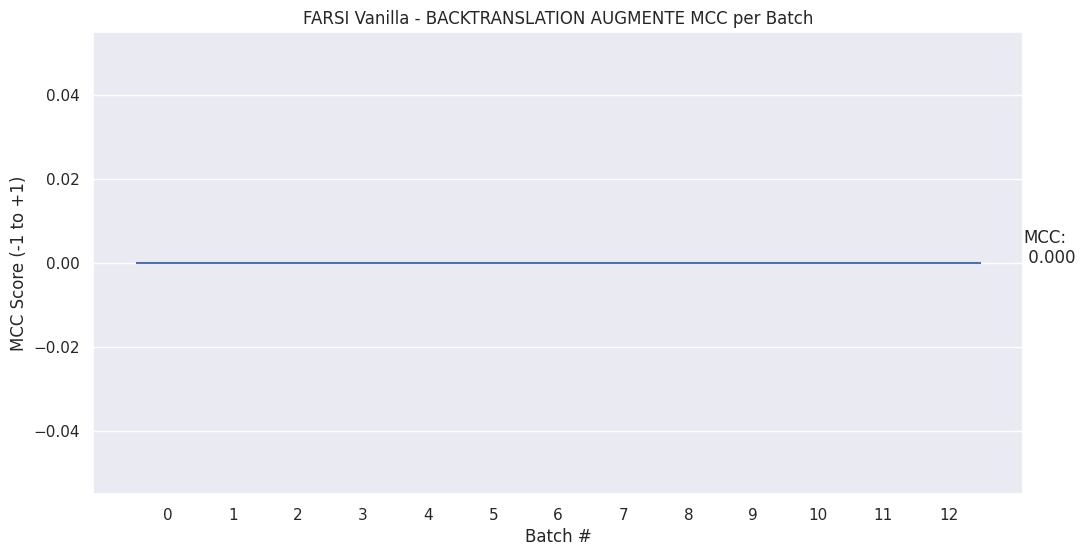

In [ ]:
# Creat a barplot of the batches' MCC scores
sns.set(color_codes=True)

ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, hue = matthews_set,
                palette="crest", legend=False)
#                palette="mako", legend=False)

ax.hlines(mcc, *ax.get_xlim())
ax.annotate(f'MCC:\n {mcc:.3f}', xy=(ax.get_xlim()[1],mcc))

plt.title('All Vanilla - BACKTRANSLATION AUGMENTE MCC per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')
plt.show()